<h1 align="center">Модель предсказания температуры сплава для металлургического комбината "Стальная птица"</h1>

<p><b>Описание проекта "Промышленность":</b></p>
<p>Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса.<p>
<p><b>Описание процесса обработки:</b><p>
<p>Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.</p>
<p>Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.
Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.</p>
<p>Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).</p>
<p><b>Описание данных:</b></p>
<p>Данные хранятся в Sqlite — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:</p>
<ul>
<li>steel.data_arc — данные об электродах;</li>
<li>steel.data_bulk — данные об объёме сыпучих материалов;</li>
<li>steel.data_bulk_time — данные о времени подачи сыпучих материалов;</li>
<li>steel.data_gas — данные о продувке сплава газом;</li>
<li>steel.data_temp — данные об измерениях температуры;</li>
<li>steel.data_wire — данные об объёме проволочных материалов;</li>
<li>steel.data_wire_time — данные о времени подачи проволочных материалов.</li>
</ul>
<p><b>Структура таблиц:</b></p>
<p>1. Таблица steel.data_arc:</p>
<ul>
    <li>key — номер партии;</li>
    <li>BeginHeat — время начала нагрева;</li>
    <li>EndHeat — время окончания нагрева;</li>
    <li>ActivePower — значение активной мощности;</li>
    <li>ReactivePower — значение реактивной мощности.</li>
</ul>
<p>2. Таблица steel.data_bulk:</p>
<ul>
    <li>key — номер партии;</li>
    <li>Bulk1 … Bulk15 — объём подаваемого материала.</li>
</ul>
<p>3. Таблица steel.data_bulk_time</p>
<ul>
    <li>key — номер партии;</li>
    <li>Bulk1 … Bulk15 — время подачи материала.</li>
</ul>
<p>4. Таблица steel.data_gas</p>
<ul>
    <li>key — номер партии;</li>
    <li>gas — объём подаваемого газа.</li>
</ul>
<p>5. Таблица steel.data_temp</p>
<ul>key — номер партии;
    <li>MesaureTime — время замера;</li>
    <li>Temperature — значение температуры.</li>
</ul>
<p>6. Таблица steel.data_wire</p>
<ul>
    <li>key — номер партии;</li>
    <li>Wire1 … Wire9 — объём подаваемых проволочных материалов.</li>
</ul>
<p>7. Таблица steel.data_wire_time</p>
<ul>
    <li>key — номер партии;</li>
    <li>Wire1 … Wire9 — время подачи проволочных материалов.</li>
</ul>
<p>Во всех файлах столбец key содержит номер партии. В таблицах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.<p>

%%html
<a id="toc"></a>
<h1>Оглавление</h1>
<ul>
    <li><a href="#model">1. Модель прогнозирования последней измеренной температуры стали</a></li>
    <li><a href="#data_analysis">2. Исследовательский анализ данных</a></li>
    <li><a href="#model_training">3. Обучение моделей</a></li>
    <li><a href="#model_testing">4. Тестирование моделей</a></li>
    <li><a href="#conclusion">5. Общий вывод по работе</a></li>
</ul>
<hr>

<a id="model"></a>
**1. Модель прогнозирования последней измеренной температуры стали**

**Постановка задачи:**

<p>Необходимо построить модель, которая будет предсказывать финальную температуру партии стали в плавильном ковше на металлургическом комбинате после выполнения итерационной последовательности технологических операций:</p>
<ul>
    <li>нагрева графитовыми электродами,</li>
    <li>подачи в сплав легирующих добавок - сыпучих материалов и проволочных материалов,</li>
    <li>продувки инертным газом.</li>
</ul>
<p>В дальнейшем модель будет использоваться для уменьшения потребления электроэнергии на этапе обработки стали.</p>
<p>Основными факторами, влияющими на температуру стали, являются:</p> 
<ul>
    <li>количество энергии потраченной на поддержание стали в расплавленном состоянии,</li>
    <li>количество поданных легирующих добавок,</li> 
    <li>данные о продувках ковша инертным газом, отнимающим энргию системы "ковш-сплав", что также влияет на температуру.</li>
</ul>
<p>В нашем распоряжении имеются данные о количественных значениях и времени подачи в систему энергии, легирующих добавок, инертного газа. Также имеются записи с датчиков температуры сплава для каждой партии.</p>
<p>Значение метрики MAE должно быть менее 6.8</p>

**Задание констант:**

In [1]:
PATH_TO_DB='./data/ds-plus-final.db'
RANDOM_STATE=42

**Импорт необходимых библиотек:**

In [2]:
#
import os
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
#
import lightgbm as gbm
#
import torch
from torch import nn
#
from catboost import CatBoostRegressor

**Связь с базой данных, подготовка импорта:**

In [4]:
engine = create_engine(f'sqlite:///{PATH_TO_DB}', echo=True)

In [5]:
def query_execution(query: str):
    try:
        data = pd.read_sql_query(query, con = engine) 
    except Exception as e:
        print(e)
        return None
    return data

**Исследование датасета с данными об электродах:**

In [6]:
query = '''
SELECT * FROM data_arc;
'''
data_arc = query_execution(query)
data_arc.head()

2026-02-08 22:06:23,279 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2026-02-08 22:06:23,279 INFO sqlalchemy.engine.Engine 
SELECT * FROM data_arc;

2026-02-08 22:06:23,280 INFO sqlalchemy.engine.Engine [raw sql] ()
2026-02-08 22:06:23,376 INFO sqlalchemy.engine.Engine ROLLBACK


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [7]:
data_arc.to_csv('data_arc.csv')

**Общая информация о датасете с данными об электродах:**

In [8]:
data_arc.info()

<class 'pandas.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  str    
 2   Конец нагрева дугой   14876 non-null  str    
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), str(2)
memory usage: 581.2 KB


Видно, что каждую партию стали нагревают несколько раз. Нагрев повышает общую энергию системы "плавильный ковш-сталь", что приводит к повышению температуры. \
Для решения задачи прогноза имеет смысл посчитать, сколько всего энергии нагревательные электроды отдали системе в ходе подготовки каждой партии стали. Для этого предлагается длительноть нагрева (EndHeat-BeginHeat) умножить на значение активной мощности (насколько понял, полезная составляющая мощности). \
    Затем сделаем сводную таблицу "номер партии - количество энергии, поступившей в систему"

**Преобразование датасета в форму, удобную для построения сводной таблицы:**

In [9]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format = '%Y-%m-%d %H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format = '%Y-%m-%d %H:%M:%S')
#dt - delta t, приращение времени
data_arc['dt'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).astype('timedelta64[s]').dt.total_seconds()
#dE - delta E, прирост энергии системы
data_arc['dE'] = data_arc['dt']*data_arc['Активная мощность']
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,dt,dE
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,69.569640
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,141.646730
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,99.813836
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,189.251040
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,128.335684


**Описание получившегося датасета:**

In [10]:
data_arc.describe().T

,count,mean,min,25%,50%,75%,max,std
key,14876.0,1615.220422,1.0,806.0,1617.0,2429.0,3241.0,934.571502
Начало нагрева дугой,14876,2019-07-05 12:25:51.921081,2019-05-03 11:02:14,2019-06-03 23:18:23.250000,2019-07-03 01:31:26.500000,2019-08-07 22:52:20.750000,2019-09-06 17:24:54,NaN
Конец нагрева дугой,14876,2019-07-05 12:28:43.592027,2019-05-03 11:06:02,2019-06-03 23:21:35,2019-07-03 01:35:13,2019-08-07 22:56:47,2019-09-06 17:26:15,NaN
Активная мощность,14876.0,0.662752,0.22312,0.467115,0.599587,0.83007,1.463773,0.258885
Реактивная мощность,14876.0,0.438986,-715.479924,0.337175,0.441639,0.608201,1.270284,5.873485
dt,14876.0,171.670946,11.0,107.0,147.0,214.0,907.0,98.186803
dE,14876.0,114.044276,5.246505,57.376903,92.194117,145.983547,898.200876,83.006059


Для нашей модели интересны пары (key - dE)

**Есть один "выброс" по реактивной мощности - удаляем:**

In [11]:
data_arc[data_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,dt,dE
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924,109.0,76.882496


In [12]:
data_arc = data_arc.drop(data_arc[data_arc['Реактивная мощность'] < 0].index, axis = 0)

In [13]:
data_arc[data_arc['Активная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,dt,dE


**Формирование сводной таблицы "Номер партии-общее количество энергии, поступившей в систему":"**

In [14]:
data_arc_pivot = pd.pivot_table(data_arc, index = 'key', values = 'dE', aggfunc = 'sum')
data_arc_pivot.head()

,dE
key,
1,628.616930
2,395.281800
3,581.774624
4,543.710274
5,412.180480


**Описательная статистика для сводной таблицы:**

In [15]:
data_arc_pivot.describe().T

,count,mean,std,min,25%,50%,75%,max
dE,3214.0,527.830044,248.775287,26.187544,358.78331,498.859124,669.173073,3718.054401


**Гистограмма распределения энергии, переданной электродами ковшу:**

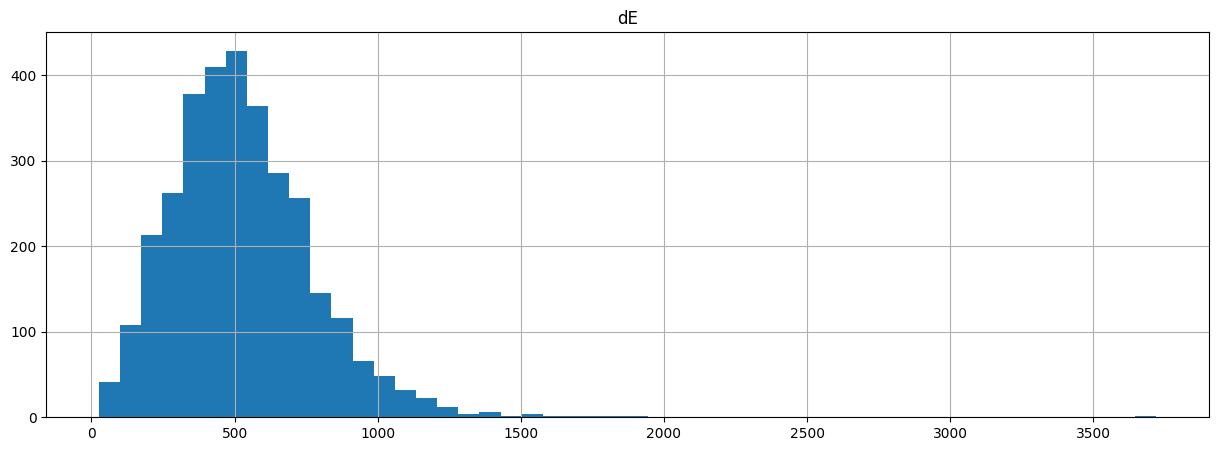

In [16]:
data_arc_pivot.hist(bins = 50, figsize = (15, 5));

**Исследование датасета, содержащего данные о подаче сыпучих материалов (объем):**

In [17]:
query = '''
SELECT * FROM data_bulk;
'''
data_bulk = query_execution(query)
data_bulk.head()

2026-02-08 22:06:23,648 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2026-02-08 22:06:23,649 INFO sqlalchemy.engine.Engine 
SELECT * FROM data_bulk;

2026-02-08 22:06:23,649 INFO sqlalchemy.engine.Engine [raw sql] ()
2026-02-08 22:06:23,662 INFO sqlalchemy.engine.Engine ROLLBACK


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [18]:
data_bulk.to_csv('data_bulk.csv')

**Получение информации о датасете:**

In [19]:
data_bulk.info()

<class 'pandas.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     str    
 6   Bulk 6   576 non-null    str    
 7   Bulk 7   25 non-null     str    
 8   Bulk 8   1 non-null      str    
 9   Bulk 9   19 non-null     str    
 10  Bulk 10  176 non-null    str    
 11  Bulk 11  177 non-null    str    
 12  Bulk 12  2450 non-null   str    
 13  Bulk 13  18 non-null     str    
 14  Bulk 14  2806 non-null   str    
 15  Bulk 15  2248 non-null   str    
dtypes: float64(4), int64(1), str(11)
memory usage: 391.3 KB


In [20]:
data_bulk.describe().T

,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.0,1622.0,2431.00,3241.0
Bulk 1,252.0,39.242063,18.277654,10.0,27.0,31.0,46.00,185.0
Bulk 2,22.0,253.045455,21.180578,228.0,242.0,251.5,257.75,325.0
Bulk 3,1298.0,113.879045,75.483494,6.0,58.0,97.5,152.00,454.0
Bulk 4,1014.0,104.394477,48.184126,12.0,72.0,102.0,133.00,281.0


Это - данные о подаче сыпучих добавок в сталь. Формата "партия - количество добавок каждого типа". Целых 15 добавок. Датасет содержит много NaN. Насколько понимаю, в нашем случае это - отсутствие подачи сыпучего материала - добавки в сталь. Предлагается заменить все NaN нулями.

In [21]:
data_bulk = data_bulk.fillna(0)

Информация, содержащаяся в данной таблице, поможет в построении модели, т.к. добавление в сплав дополнительных материалов неизбежно изменит температуру.

Данные о подаче сыпучих материалов (время):

In [22]:
query = '''
SELECT * FROM data_bulk_time;
'''
data_bulk_time = query_execution(query)
data_bulk_time.head(5)

2026-02-08 22:06:23,713 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2026-02-08 22:06:23,714 INFO sqlalchemy.engine.Engine 
SELECT * FROM data_bulk_time;

2026-02-08 22:06:23,714 INFO sqlalchemy.engine.Engine [raw sql] ()
2026-02-08 22:06:23,728 INFO sqlalchemy.engine.Engine ROLLBACK


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [23]:
data_bulk_time.to_csv('data_bulk_time.csv')

**Получение информации о датасете:**

In [24]:
data_bulk_time.info()

<class 'pandas.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   key      3129 non-null   int64
 1   Bulk 1   252 non-null    str  
 2   Bulk 2   22 non-null     str  
 3   Bulk 3   1298 non-null   str  
 4   Bulk 4   1014 non-null   str  
 5   Bulk 5   77 non-null     str  
 6   Bulk 6   576 non-null    str  
 7   Bulk 7   25 non-null     str  
 8   Bulk 8   1 non-null      str  
 9   Bulk 9   19 non-null     str  
 10  Bulk 10  176 non-null    str  
 11  Bulk 11  177 non-null    str  
 12  Bulk 12  2450 non-null   str  
 13  Bulk 13  18 non-null     str  
 14  Bulk 14  2806 non-null   str  
 15  Bulk 15  2248 non-null   str  
dtypes: int64(1), str(15)
memory usage: 391.3 KB


Это - данные о времени подачи сыпучих добавок в сталь. Формат и логика заполнения повторяет таблицу о количественных значениях подачи добавок в сталь. Используя эту таблицу и таблицу data_bulk можно найти время и количество подачи каждой добавки в сталь. \
Данную таблицу предлагается не использовать в модели, будем использовать только даннные о количестве подачи сыпучих  добавок.

**Данные о продувке сплава инертным газом:**

In [25]:
query = '''
SELECT * FROM data_gas;
'''
data_gas = query_execution(query)
data_gas.head()

2026-02-08 22:06:23,759 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2026-02-08 22:06:23,760 INFO sqlalchemy.engine.Engine 
SELECT * FROM data_gas;

2026-02-08 22:06:23,760 INFO sqlalchemy.engine.Engine [raw sql] ()
2026-02-08 22:06:23,765 INFO sqlalchemy.engine.Engine ROLLBACK


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [26]:
data_gas.to_csv('data_gas.csv')

**Получение информации о датасете:**

In [27]:
data_gas.info()

<class 'pandas.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [28]:
data_gas.describe().T

,count,mean,std,min,25%,50%,75%,max
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000
Газ 1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


Данные о продувках инертным газом имеют формат "номер партии - объем продувки". Продувка газом влияет на температуру партии, насколько понимаю, отводит энергию из системы, уменьшая температуру. Необходимо использовать данные, содержащиеся в датасете в модели.

**Результаты измерения температуры:**

In [29]:
query = '''
SELECT * FROM data_temp;
'''
data_temp = query_execution(query)
data_temp.head()

2026-02-08 22:06:23,795 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2026-02-08 22:06:23,795 INFO sqlalchemy.engine.Engine 
SELECT * FROM data_temp;

2026-02-08 22:06:23,796 INFO sqlalchemy.engine.Engine [raw sql] ()
2026-02-08 22:06:23,819 INFO sqlalchemy.engine.Engine ROLLBACK


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Температуру измеряют несколько раз в течение подготовки каждой партии.

In [30]:
data_temp.to_csv('data_temp.csv')

In [31]:
data_temp.info()

<class 'pandas.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   key           18092 non-null  int64
 1   Время замера  18092 non-null  str  
 2   Температура   14665 non-null  str  
dtypes: int64(1), str(2)
memory usage: 424.2 KB


**Преобразование датасета, установка необходимых типов данных:**

In [32]:
pd.to_datetime(data_temp['Время замера'])

0       2019-05-03 11:02:04
1       2019-05-03 11:07:18
2       2019-05-03 11:11:34
3       2019-05-03 11:18:04
4       2019-05-03 11:25:59
                ...        
18087   2019-09-06 16:55:01
18088   2019-09-06 17:06:38
18089   2019-09-06 17:21:48
18090   2019-09-06 17:24:44
18091   2019-09-06 17:30:05
Name: Время замера, Length: 18092, dtype: datetime64[us]

In [33]:
data_temp['Температура'] = data_temp['Температура'].astype(float)

In [34]:
data_temp.describe().T

,count,mean,std,min,25%,50%,75%,max
key,18092.0,1616.460977,934.641385,1.0,807.75,1618.0,2429.0,3241.0
Температура,14665.0,1590.722741,20.394381,1191.0,1580.00,1590.0,1599.0,1705.0


Также видно, что минимальная измеренная температура стали - 1191 градус. Гугл говорит, что ткмпература плавления стали 1300-1500 градусов. Строки в которых измеренная температура меньше 1300 градусов предлагается удалить. Либо неправильно измерена температура, либо сталь станет твердым телом!

In [35]:
data_temp[data_temp['Температура'] < 1300]

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


In [36]:
data_temp = data_temp.drop(data_temp[data_temp['Температура'] < 1300].index, axis = 0)

In [37]:
data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [38]:
data_temp[data_temp['Температура'] < 1300]

,key,Время замера,Температура


Отсутствующие данные:

In [39]:
data_temp[data_temp['Температура'].isna()]

,key,Время замера,Температура
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
13932,2501,2019-08-10 14:49:15,NaN
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


Часть данных об измерениях температуры отсутствует. Открывая данный датасет в какой-л. электронной таблице можно подметить, что начиная с партии №2500 данные о температуре есть только для первого измерения. Данных о последней измененной температуре - в этих случаях нет, обучить модель на этих данных не представляется возможным. Поэтому данные для обучения надо будет ограничить информацией о первых 2499 партиях.

Поэтому формулировка нового запроса к базе данных: из таблицы steel.data_temp для каждой партии стали выбрать первую и последнюю измеренные температуры. Это - задача для оконных функций postgresql.

In [40]:
query = '''
SELECT DISTINCT key, 
        FIRST_VALUE("Температура") OVER (PARTITION BY key) AS first_temp,
        LAST_VALUE("Температура") OVER (PARTITION BY key) AS last_temp
FROM data_temp
WHERE key < 2500
ORDER BY key;
'''
data_temp_first_last = query_execution(query)

2026-02-08 22:06:23,919 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2026-02-08 22:06:23,919 INFO sqlalchemy.engine.Engine 
SELECT DISTINCT key, 
        FIRST_VALUE("Температура") OVER (PARTITION BY key) AS first_temp,
        LAST_VALUE("Температура") OVER (PARTITION BY key) AS last_temp
FROM data_temp
WHERE key < 2500
ORDER BY key;

2026-02-08 22:06:23,920 INFO sqlalchemy.engine.Engine [raw sql] ()
2026-02-08 22:06:23,935 INFO sqlalchemy.engine.Engine ROLLBACK


In [41]:
data_temp_first_last

,key,first_temp,last_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2472,2495,1570.0,1591.0
2473,2496,1554.0,1591.0
2474,2497,1571.0,1589.0
2475,2498,1591.0,1594.0


<u>last_temp будет нашим таргетом.</u> Прогнозируем последнюю измеренную температуру.

**Данные о проволочных материалах (объем):**

In [42]:
query = '''
SELECT * FROM data_wire;
'''
data_wire = query_execution(query)
data_wire.head()

2026-02-08 22:06:23,946 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2026-02-08 22:06:23,946 INFO sqlalchemy.engine.Engine 
SELECT * FROM data_wire;

2026-02-08 22:06:23,946 INFO sqlalchemy.engine.Engine [raw sql] ()
2026-02-08 22:06:23,955 INFO sqlalchemy.engine.Engine ROLLBACK


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
data_wire.to_csv('data_wire.csv')

**Получение информации о датасете:**

In [44]:
data_wire.info()

<class 'pandas.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   str    
 3   Wire 3  63 non-null     str    
 4   Wire 4  14 non-null     str    
 5   Wire 5  1 non-null      str    
 6   Wire 6  73 non-null     str    
 7   Wire 7  11 non-null     str    
 8   Wire 8  19 non-null     str    
 9   Wire 9  29 non-null     str    
dtypes: float64(1), int64(1), str(8)
memory usage: 240.8 KB


**Преобразование датасета, уствновка необходимых типов данных:**

In [45]:
data_wire[['Wire 1','Wire 2','Wire 3','Wire 4','Wire 5','Wire 6','Wire 7','Wire 8','Wire 9']] = data_wire[['Wire 1','Wire 2','Wire 3','Wire 4','Wire 5','Wire 6','Wire 7','Wire 8','Wire 9']].astype(float)

In [46]:
data_wire = data_wire.fillna(0)

In [47]:
data_wire.describe().T

,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.0,823.00000,1619.000000,2434.000000,3241.000000
Wire 1,3081.0,100.044411,42.841120,0.0,70.28112,100.114563,125.798405,330.314424
Wire 2,3081.0,17.712733,33.517734,0.0,0.00000,0.000000,23.162880,282.780152
Wire 3,3081.0,3.874524,30.310417,0.0,0.00000,0.000000,0.000000,385.008668
Wire 4,3081.0,0.261019,4.293865,0.0,0.00000,0.000000,0.000000,113.231044
Wire 5,3081.0,0.004911,0.272615,0.0,0.00000,0.000000,0.000000,15.132000
Wire 6,3081.0,1.137695,8.958111,0.0,0.00000,0.000000,0.000000,180.454575
Wire 7,3081.0,0.035842,0.774190,0.0,0.00000,0.000000,0.000000,32.847674
Wire 8,3081.0,0.330697,4.392677,0.0,0.00000,0.000000,0.000000,102.762401
Wire 9,3081.0,0.321492,3.806904,0.0,0.00000,0.000000,0.000000,90.053604


Здесь - аналогично данным о сыпучих добавках. Только типов проволочек - 9.

**Данные о проволочных материалах (время):**

In [48]:
query = '''
SELECT * FROM data_wire_time;
'''
data_wire_time = query_execution(query)
data_wire_time.head()

2026-02-08 22:06:24,009 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2026-02-08 22:06:24,010 INFO sqlalchemy.engine.Engine 
SELECT * FROM data_wire_time;

2026-02-08 22:06:24,010 INFO sqlalchemy.engine.Engine [raw sql] ()
2026-02-08 22:06:24,019 INFO sqlalchemy.engine.Engine ROLLBACK


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
data_wire_time.to_csv('data_wire_time.csv')

**Получение информации о датасете:**

In [50]:
data_wire_time.info()

<class 'pandas.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   key     3081 non-null   int64
 1   Wire 1  3055 non-null   str  
 2   Wire 2  1079 non-null   str  
 3   Wire 3  63 non-null     str  
 4   Wire 4  14 non-null     str  
 5   Wire 5  1 non-null      str  
 6   Wire 6  73 non-null     str  
 7   Wire 7  11 non-null     str  
 8   Wire 8  19 non-null     str  
 9   Wire 9  29 non-null     str  
dtypes: int64(1), str(9)
memory usage: 240.8 KB


In [51]:
data_wire_time.describe().T

,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.0,823.0,1619.0,2434.0,3241.0


Данные о времени подачи легирующих проволок предлагается не использовать в модели.

**Объединение данных, подготовка набора данных:**

Общий для всех таблиц ключ для объединения - key (номер партии).

In [52]:
data = (data_temp_first_last
        .merge(data_arc_pivot, on = 'key', how = 'left')
        .merge(data_bulk, on = 'key', how = 'left')
        .merge(data_gas, on = 'key', how = 'left')
        .merge(data_wire, on = 'key', how = 'left')
       )

In [53]:
data.head()

,key,first_temp,last_temp,dE,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1571.0,1613.0,628.616930,0.0,0.0,0.0,43.0,0,0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,395.281800,0.0,0.0,0.0,73.0,0,0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,581.774624,0.0,0.0,0.0,34.0,0,0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,543.710274,0.0,0.0,0.0,81.0,0,0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,412.180480,0.0,0.0,0.0,78.0,0,0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
data = data.fillna(0)

In [55]:
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 2477 entries, 0 to 2476
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2477 non-null   int64  
 1   first_temp  2477 non-null   str    
 2   last_temp   2477 non-null   str    
 3   dE          2477 non-null   float64
 4   Bulk 1      2477 non-null   float64
 5   Bulk 2      2477 non-null   float64
 6   Bulk 3      2477 non-null   float64
 7   Bulk 4      2477 non-null   float64
 8   Bulk 5      2477 non-null   object 
 9   Bulk 6      2477 non-null   object 
 10  Bulk 7      2477 non-null   object 
 11  Bulk 8      2477 non-null   object 
 12  Bulk 9      2477 non-null   object 
 13  Bulk 10     2477 non-null   object 
 14  Bulk 11     2477 non-null   object 
 15  Bulk 12     2477 non-null   object 
 16  Bulk 13     2477 non-null   object 
 17  Bulk 14     2477 non-null   object 
 18  Bulk 15     2477 non-null   object 
 19  Газ 1       2477 non-null   float64
 2

<a href="#toc">**к оглавлению**</a>

<a id="data_analysis"></a>
**2. Исследовательский анализ данных:**

Для каждого значения столбца key найдите:
- Сколько времени прошло между первым и последним замером температуры;
- Суммарное время нагрева электродами, то есть сумму значений по всем промежуткам между запусками нагрева электродами;
- Количество запусков нагрева электродами;
- Среднее соотношение потребления активной и реактивной мощности.

По всем полученным столбцам вычислите статистические показатели: средние, минимальные и максимальные значения, медиану и величины квартилей 25% и 75%. (применить describe() иными словами).

**Сколько времени прошло между первым и последним замером температуры. Информация записывается в столбец dt:**

In [56]:
query = '''
SELECT key,
        MIN("Время замера") AS first_time,
        MAX("Время замера") AS last_time,
        strftime('%s', MAX("Время замера")) - strftime('%s', MIN("Время замера")) AS dt
FROM data_temp
GROUP BY key
ORDER BY key;
'''
data_temp_first_last = query_execution(query)
data_temp_first_last.head()

2026-02-08 22:06:24,106 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2026-02-08 22:06:24,107 INFO sqlalchemy.engine.Engine 
SELECT key,
        MIN("Время замера") AS first_time,
        MAX("Время замера") AS last_time,
        strftime('%s', MAX("Время замера")) - strftime('%s', MIN("Время замера")) AS dt
FROM data_temp
GROUP BY key
ORDER BY key;

2026-02-08 22:06:24,107 INFO sqlalchemy.engine.Engine [raw sql] ()
2026-02-08 22:06:24,120 INFO sqlalchemy.engine.Engine ROLLBACK


,key,first_time,last_time,dt
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1714
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1265
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1753
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1220
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1536


**Информация о датасете:**

In [57]:
data_temp_first_last.info()

<class 'pandas.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   key         3216 non-null   int64
 1   first_time  3216 non-null   str  
 2   last_time   3216 non-null   str  
 3   dt          3216 non-null   int64
dtypes: int64(2), str(2)
memory usage: 100.6 KB


**Первичный анализ данных о разности времени замеров каждой партии:**

In [58]:
data_temp_first_last['dt'].describe().T

count     3216.000000
mean      2249.620958
std       1317.270815
min          0.000000
25%       1528.000000
50%       1987.000000
75%       2706.000000
max      23674.000000
Name: dt, dtype: float64

**Гистограмма распределения времени между первым и последним замером температуры каждой партии:**

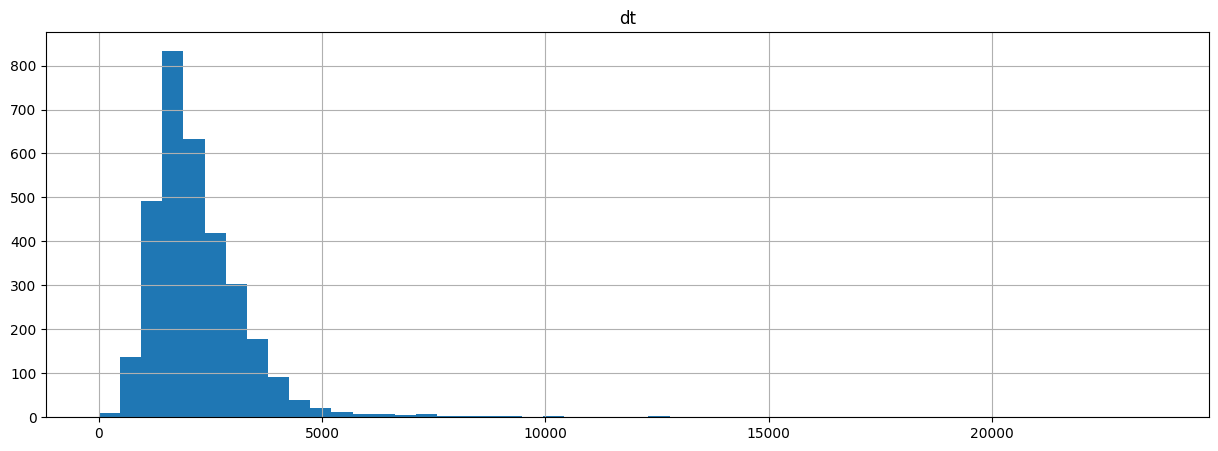

In [59]:
data_temp_first_last.hist(column='dt', bins = 50, figsize = (15, 5));

**Суммарное время нагрева электродами, то есть сумму значений по всем промежуткам между запусками нагрева электродами:**

In [60]:
data_arc_key_time = pd.pivot_table(data_arc, index = 'key', values = 'dt', aggfunc = 'sum')
data_arc_key_time.head()

,dt
key,
1,1098.0
2,811.0
3,655.0
4,741.0
5,869.0


**Первичный анализ данных о суммарном времени нагрева электродами:**

In [61]:
data_arc_key_time['dt'].describe()

count    3214.000000
mean      794.545115
std       332.491076
min        57.000000
25%       571.000000
50%       770.000000
75%       983.000000
max      4189.000000
Name: dt, dtype: float64

**Гистограмма распределения суммарного времени нагрева электродами:**

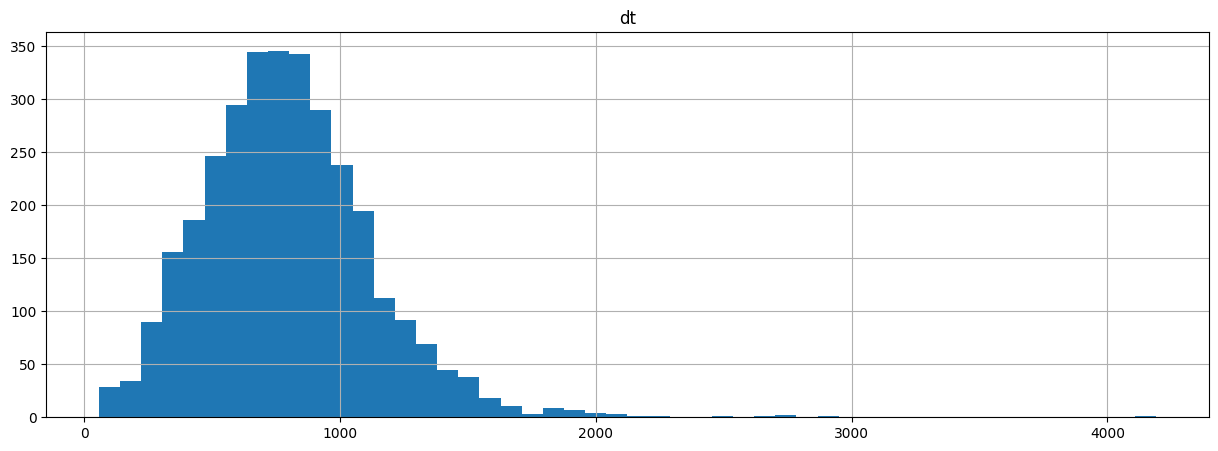

In [62]:
data_arc_key_time.hist(column='dt', bins = 50, figsize = (15, 5));

**Количество запусков нагрева электродами:**

In [63]:
data_arc_key_count = pd.pivot_table(data_arc, index = 'key', values = 'dt', aggfunc = 'count')
data_arc_key_count.head()

,dt
key,
1,5
2,4
3,5
4,4
5,4


**Первичный анализ данных о количестве запусков нагрева электродами:**

In [64]:
data_arc_key_count['dt'].describe()

count    3214.000000
mean        4.628189
std         1.608866
min         1.000000
25%         4.000000
50%         4.000000
75%         6.000000
max        16.000000
Name: dt, dtype: float64

**Гистограмма распределения количества запусков нагрева электродами:**

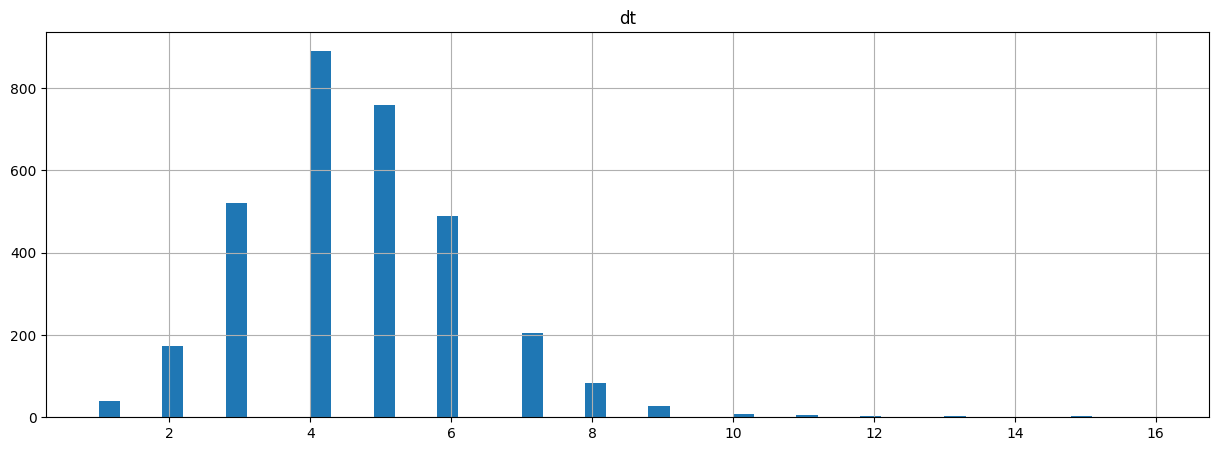

In [65]:
data_arc_key_count.hist(column='dt', bins = 50, figsize = (15, 5));

**Среднее соотношение потребления активной и реактивной мощности:**

Подготовка сводной таблицы:

In [66]:
data_arc_key_power = pd.pivot_table(data_arc, index = 'key', values = ['Активная мощность', 'Реактивная мощность'], aggfunc = 'mean')
data_arc_key_power['mean_ratio'] = data_arc_key_power['Активная мощность'] / data_arc_key_power['Реактивная мощность']
data_arc_key_power.head()

,Активная мощность,Реактивная мощность,mean_ratio
key,,,
1,0.607346,0.428564,1.417165
2,0.534852,0.363339,1.472046
3,0.812728,0.587491,1.383387
4,0.676622,0.514248,1.315751
5,0.563238,0.421998,1.334693


**Первичный анализ данных, гистограммы распределения активной, реактивной мощностей и их соотношения:**

In [67]:
data_arc_key_power.describe().T

,count,mean,std,min,25%,50%,75%,max
Активная мощность,3214.0,0.661327,0.128372,0.267676,0.573035,0.652732,0.739388,1.243889
Реактивная мощность,3214.0,0.485972,0.097586,0.196228,0.417415,0.481639,0.543312,0.960763
mean_ratio,3214.0,1.364276,0.069890,1.099467,1.317860,1.364847,1.410687,1.663366


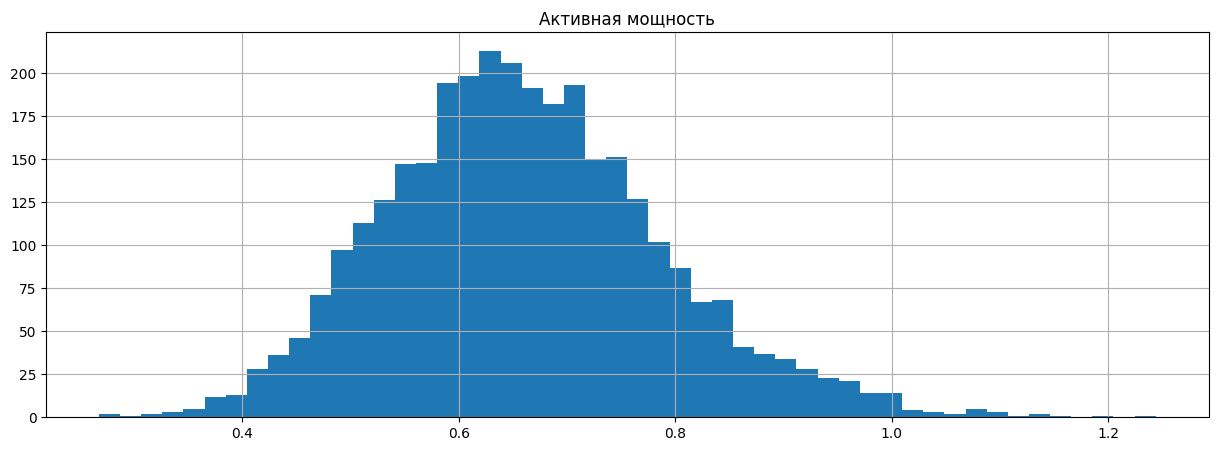

In [68]:
data_arc_key_power.hist(column='Активная мощность', bins = 50, figsize = (15, 5));

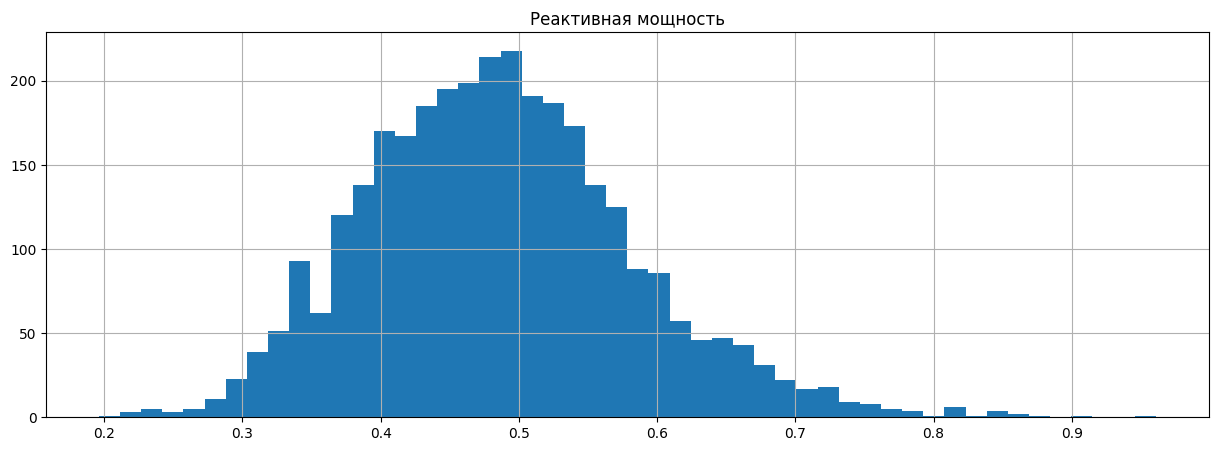

In [69]:
data_arc_key_power.hist(column='Реактивная мощность', bins = 50, figsize = (15, 5));

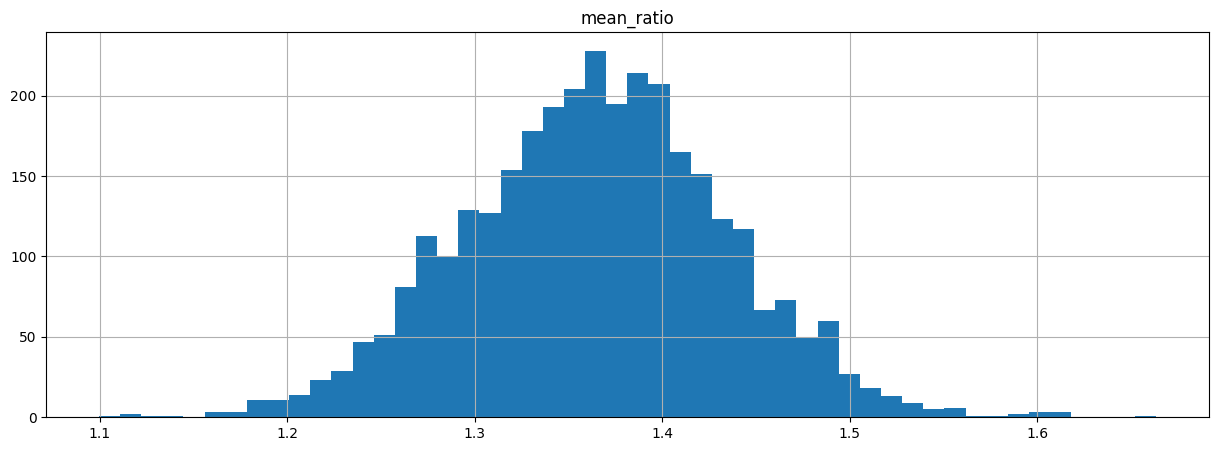

In [70]:
data_arc_key_power.hist(column='mean_ratio', bins = 50, figsize = (15, 5));

<a href="#toc">**к оглавлению**</a>

<a id="model_training"></a>
**3. Обучение моделей:**

**Подготовка тренировочных и тестовых данных. Качество обучения модели будет проверяться кросс-валидацией.**

In [71]:
data.head()

,key,first_temp,last_temp,dE,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1571.0,1613.0,628.616930,0.0,0.0,0.0,43.0,0,0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,395.281800,0.0,0.0,0.0,73.0,0,0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,581.774624,0.0,0.0,0.0,34.0,0,0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,543.710274,0.0,0.0,0.0,81.0,0,0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,412.180480,0.0,0.0,0.0,78.0,0,0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
target = data['last_temp'].astype(float)
features = data.drop(['key','last_temp'], axis = 1)

In [73]:
target.info()

<class 'pandas.Series'>
RangeIndex: 2477 entries, 0 to 2476
Series name: last_temp
Non-Null Count  Dtype  
--------------  -----  
2477 non-null   float64
dtypes: float64(1)
memory usage: 19.5 KB


Проверка степени тесноты связи факторов модели:

C:\Users\dmatv\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\misc.py:99: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
C:\Users\dmatv\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\misc.py:100: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
C:\Users\dmatv\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\misc.py:90: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


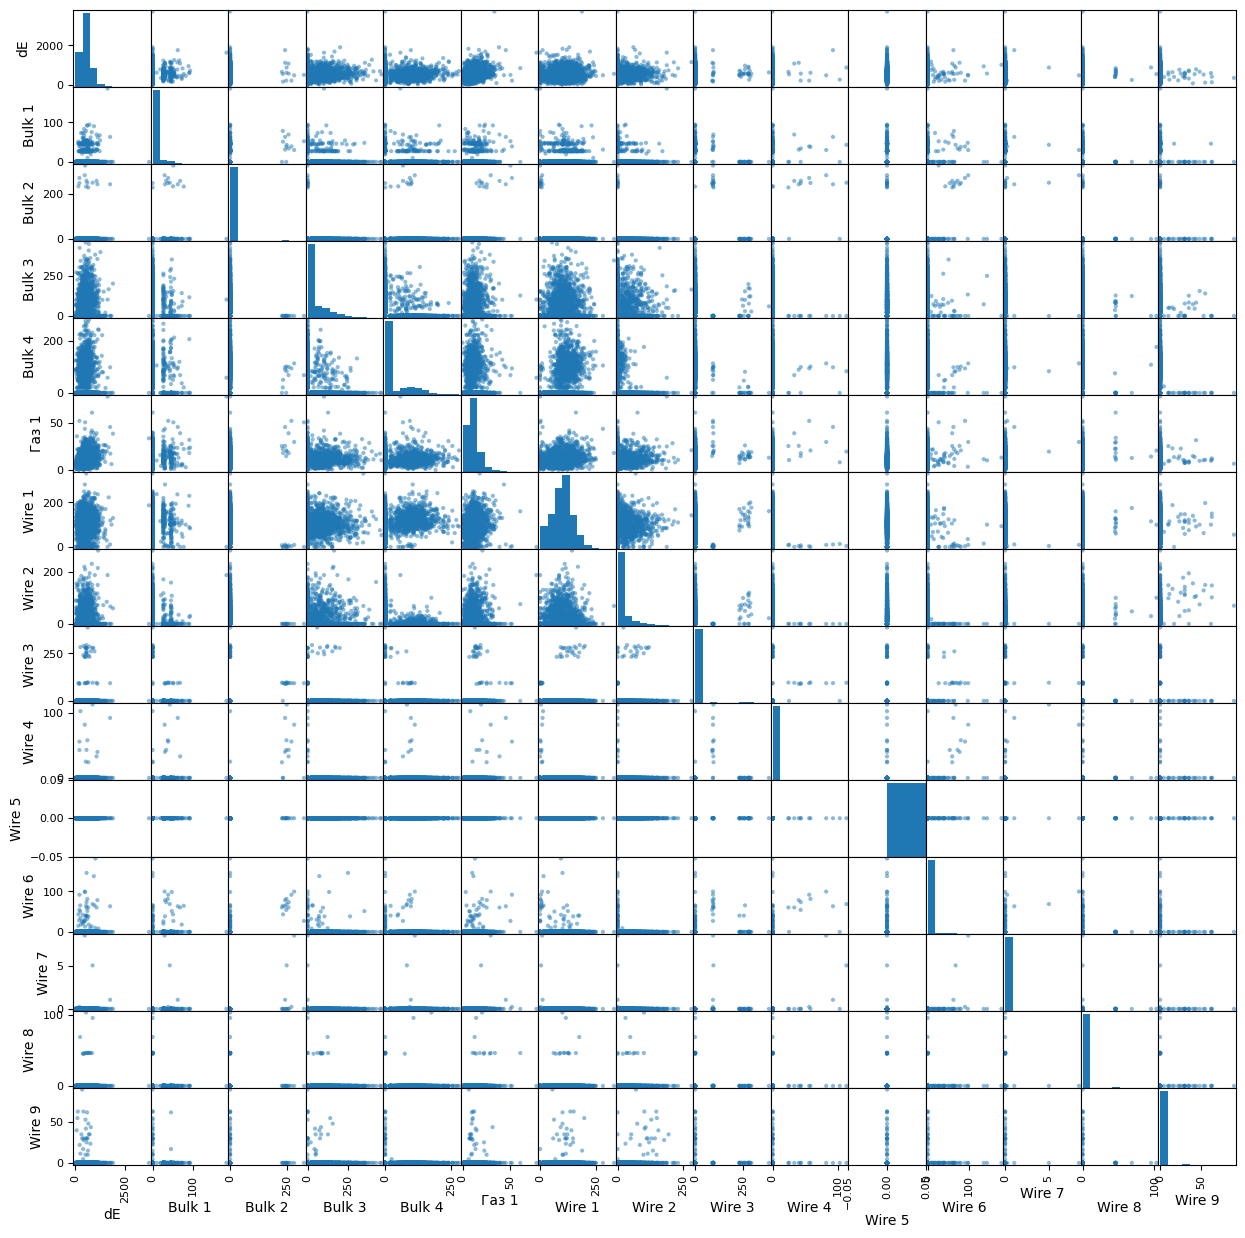

In [74]:
pd.plotting.scatter_matrix(features, figsize=(15, 15));

Видно, что сильной тесноты связи попарно между признаками не наблюдается, поэтому используем их все в модели.

In [75]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = .25,random_state = 42)

In [76]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(1857, 27)
(620, 27)
(1857,)
(620,)


In [77]:
scaler = StandardScaler()
scaler.fit(features_train[features_train.columns])
features_train_scaled = pd.DataFrame(scaler.transform(features_train), columns = features_train.columns)
features_test_scaled = pd.DataFrame(scaler.transform(features_test), columns = features_test.columns)

In [78]:
features_train_scaled.head()

,first_temp,dE,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,...,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,-0.053997,-0.543072,-0.269784,-0.073152,-0.608688,-0.601775,-0.113823,-0.388888,-0.065521,-0.023212,...,0.519235,1.375604,0.814249,-0.114498,-0.06278,0.0,-0.109882,-0.023844,-0.061728,-0.100875
1,-1.716523,-0.010404,-0.269784,-0.073152,0.538290,-0.601775,-0.113823,-0.388888,-0.065521,-0.023212,...,1.113070,-0.590817,1.692854,-0.114498,-0.06278,0.0,-0.109882,-0.023844,-0.061728,-0.100875
2,0.043798,-0.181710,-0.269784,-0.073152,0.751681,-0.601775,-0.113823,1.564923,-0.065521,-0.023212,...,0.754856,0.469187,0.373622,-0.114498,-0.06278,0.0,-0.109882,-0.023844,-0.061728,-0.100875
3,-1.129749,0.722590,-0.269784,-0.073152,-0.608688,-0.601775,-0.113823,0.076305,-0.065521,-0.023212,...,2.210514,-1.375293,-0.060824,-0.114498,-0.06278,0.0,-0.109882,-0.023844,-0.061728,-0.100875
4,-1.194947,0.005542,-0.269784,-0.073152,-0.195242,-0.601775,-0.113823,-0.388888,-0.065521,-0.023212,...,0.081983,-0.973313,-0.507632,-0.114498,-0.06278,0.0,-0.109882,-0.023844,-0.061728,-0.100875


In [79]:
features_test_scaled.head()

,first_temp,dE,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,...,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,0.369784,-1.190022,-0.269784,-0.073152,-0.355286,-0.601775,-0.113823,-0.388888,-0.065521,-0.023212,...,-1.112113,-0.848757,1.347593,-0.114498,-0.06278,0.0,-0.109882,-0.023844,-0.061728,-0.100875
1,0.239390,0.233820,-0.269784,-0.073152,-0.608688,1.409701,-0.113823,-0.388888,-0.065521,-0.023212,...,1.744524,0.935113,-0.507632,-0.114498,-0.06278,0.0,-0.109882,-0.023844,-0.061728,-0.100875
2,-0.282187,1.249136,-0.269784,-0.073152,-0.608688,1.981931,-0.113823,-0.388888,-0.065521,-0.023212,...,0.521038,0.050861,-0.507632,-0.114498,-0.06278,0.0,-0.109882,-0.023844,-0.061728,-0.100875
3,-0.379983,-1.128111,-0.269784,-0.073152,-0.608688,-0.601775,-0.113823,1.657961,-0.065521,-0.023212,...,-0.894766,-0.770296,-0.507632,-0.114498,-0.06278,0.0,-0.109882,-0.023844,-0.061728,-0.100875
4,0.011200,-0.047220,2.116270,-0.073152,-0.608688,-0.601775,-0.113823,1.229984,-0.065521,-0.023212,...,-1.548486,-1.205034,-0.507632,-0.114498,-0.06278,0.0,-0.109882,-0.023844,-0.061728,-0.100875


**Обучение модели линейной регрессии**

In [80]:
model_lire = LinearRegression(n_jobs = -1)
scores = cross_val_score(model_lire, features_train_scaled, target_train, cv = 5, scoring = 'neg_mean_absolute_error', n_jobs = -1)
print(f'mae={-(sum(scores)/len(scores))}')

mae=9.251218969294563


**Обучение модели случайного дерева**

In [81]:
%%time
min_mae = 10000
min_depth = -1
optimal_tree = None
for depth in range(1,101):
    model_tree = DecisionTreeRegressor(criterion='absolute_error', max_depth = depth, random_state = 42)
    scores = cross_val_score(model_tree, features_train_scaled, target_train, cv = 5, scoring = 'neg_mean_absolute_error', n_jobs = -1)
    temp_mae = -(sum(scores)/len(scores))
    if temp_mae < min_mae:
        min_mae = temp_mae
        min_depth = depth
        optimal_tree = model_tree
        print(f'depth = {min_depth}, mae = {min_mae}')
print('==========ИТОГ==========')
print(f'depth = {min_depth}, mae = {min_mae}')

depth = 1, mae = 9.293607802220098
depth = 2, mae = 8.445835144770019
depth = 3, mae = 8.143722285018693
depth = 4, mae = 7.940408805031447
depth = 5, mae = 7.896406109613656
depth = 6, mae = 7.788475639799438
depth = 7, mae = 7.775255774860158
==========ИТОГ==========
depth = 7, mae = 7.775255774860158
CPU times: total: 500 ms
Wall time: 13.3 s


**Градиентные бустинги!**

**Использование sklearn.GradientBoostingRegressor:**

In [82]:
model_gbr = GradientBoostingRegressor()
Params = {
    'loss' : ['absolute_error'],
    'learning_rate': [0.05, 0.01],
    'n_estimators': [100,120,140],
    'max_depth': [12,15,16,17],
    'random_state': [42],
    'max_leaf_nodes': [140, 150]
    }

In [83]:
%%time
grid_gbr = GridSearchCV(model_gbr, Params, verbose=1, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
grid_gbr.fit(features_train_scaled, target_train)
print(grid_gbr.best_params_)
print(-grid_gbr.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'learning_rate': 0.05, 'loss': 'absolute_error', 'max_depth': 17, 'max_leaf_nodes': 150, 'n_estimators': 140, 'random_state': 42}
6.843225510131279
CPU times: total: 4.25 s
Wall time: 1min 40s


**Использование light GBM:**

In [84]:
model = gbm.LGBMRegressor()
gridParams = {
    'learning_rate': [0.05, 0.01],
    'n_estimators': [50, 100,120,140],
    'max_depth': [6,10,15,20],
    'num_leaves': [100,120,140],
    'boosting_type' : ['gbdt'],
    'eval_metric' : ['mae'],
    'n_jobs' : [-1]
    }

In [85]:
%%time
grid_lgbm = GridSearchCV(model, gridParams, verbose=1, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
grid_lgbm.fit(features_train_scaled, target_train)
print(grid_lgbm.best_params_)
print(-grid_lgbm.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1988
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 18
[LightGBM] [Info] Start training from score 1595.398492
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

In [86]:
%%time
model_cat = CatBoostRegressor(loss_function="MAE", iterations=200)
model_cat.fit(features_train_scaled, target_train)

0:	learn: 9.9131008	total: 145ms	remaining: 28.9s
1:	learn: 9.8144396	total: 146ms	remaining: 14.5s
2:	learn: 9.7105663	total: 148ms	remaining: 9.7s
3:	learn: 9.6340247	total: 149ms	remaining: 7.3s
4:	learn: 9.5326690	total: 150ms	remaining: 5.86s
5:	learn: 9.4441559	total: 152ms	remaining: 4.91s
6:	learn: 9.3860359	total: 153ms	remaining: 4.22s
7:	learn: 9.3215857	total: 154ms	remaining: 3.71s
8:	learn: 9.2605391	total: 156ms	remaining: 3.31s
9:	learn: 9.2003038	total: 157ms	remaining: 2.98s
10:	learn: 9.1401629	total: 158ms	remaining: 2.72s
11:	learn: 9.0558928	total: 160ms	remaining: 2.5s
12:	learn: 8.9950693	total: 161ms	remaining: 2.32s
13:	learn: 8.9567250	total: 163ms	remaining: 2.16s
14:	learn: 8.9161705	total: 164ms	remaining: 2.02s
15:	learn: 8.8538816	total: 165ms	remaining: 1.9s
16:	learn: 8.7963887	total: 167ms	remaining: 1.79s
17:	learn: 8.7291857	total: 168ms	remaining: 1.7s
18:	learn: 8.6519120	total: 169ms	remaining: 1.61s
19:	learn: 8.6001496	total: 171ms	remaining: 1

**Использование нейронной сети:**

In [87]:
def NN_initialize(n_neurons):
    net_layers = []
    for i in range(1, len(n_neurons) - 1):
        net_layers.append(nn.Linear(n_neurons[i-1], n_neurons[i]))
        if i in [1, 2, 3, 4]:
            net_layers.append(nn.Dropout(.25))
        net_layers.append(nn.ReLU())
    #
    net_layers.append(nn.Linear(n_neurons[-2], n_neurons[-1])) # добавление выходного слоя 
    #net_layers.append(nn.ReLU()) #Функция активации для выходного слоя:
    net = nn.Sequential(*net_layers)
    print(net) # вывод архитектуры сети
    return net

In [88]:
class CustomEarlyStopping():
    """
    Ранняя остановка, чтобы остановить тренировку, когда потеря не улучшается после определенной эпохи.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: сколько эпох ждать, прежде чем остановиться, когда потеря не улучшается
        :param min_delta: минимальная разница между loss/метриками, если улучшений нет, то остановим обучение
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [89]:
def net_learn(net):    
    xx = []
    yy_train_loss = []
    yy_test_loss = []

    early_stopping = CustomEarlyStopping(patience=1, min_delta=1)

    num_epochs = 100000

    for epoch in range(num_epochs):
        net.train()
        optimizer.zero_grad()
        train_preds = net.forward(torch.FloatTensor(features_train_scaled.values)).flatten()
        loss_value = loss(train_preds, torch.FloatTensor(target_train.values))
        loss_value.backward()
        optimizer.step()
        if epoch % 100 == 0 or epoch == num_epochs:
            net.eval()
            with torch.no_grad(): # отключаем вычисление градиентов
                xx.append(epoch)
                test_preds = net.forward(torch.FloatTensor(features_test_scaled.values)).flatten()
                mae_train = mean_absolute_error(target_train, train_preds.detach().numpy())
                yy_train_loss.append(mae_train)
                mae_test = mean_absolute_error(target_test, test_preds.detach().numpy())
                yy_test_loss.append(mae_test)
                early_stopping(mae_test)
                if early_stopping.early_stop:
                    #print('Epoch: {}, rmse train: {}, rmse test:{}'.format(epoch, rmse_train, rmse_test))
                    break
                    
    return xx, yy_train_loss, yy_test_loss

In [90]:
%%time
n_neurons = [features_train_scaled.shape[1], 4096, 2048, 1024, 512, 256, 64, 32, 1]
net = NN_initialize(n_neurons)
#Выбор оптимизатора
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
#Выбор функции потерь
loss = torch.nn.L1Loss()
xx, yy_train_loss, yy_test_loss = net_learn(net)

Sequential(
  (0): Linear(in_features=27, out_features=4096, bias=True)
  (1): Dropout(p=0.25, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=4096, out_features=2048, bias=True)
  (4): Dropout(p=0.25, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=2048, out_features=1024, bias=True)
  (7): Dropout(p=0.25, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=1024, out_features=512, bias=True)
  (10): Dropout(p=0.25, inplace=False)
  (11): ReLU()
  (12): Linear(in_features=512, out_features=256, bias=True)
  (13): ReLU()
  (14): Linear(in_features=256, out_features=64, bias=True)
  (15): ReLU()
  (16): Linear(in_features=64, out_features=32, bias=True)
  (17): ReLU()
  (18): Linear(in_features=32, out_features=1, bias=True)
)


C:\Users\dmatv\AppData\Local\Temp\ipykernel_2744\1820740191.py:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:219.)
  train_preds = net.forward(torch.FloatTensor(features_train_scaled.values)).flatten()


INFO: Early stopping counter 1 of 1
INFO: Early stopping
CPU times: total: 39min 26s
Wall time: 6min 35s


In [91]:
print(yy_train_loss)
print(yy_test_loss)

[1595.2557848512677, 392.35091579685815, 143.64826810032562, 94.6317528153082, 79.09069492255864, 73.04882815786762, 74.94625320393486, 69.79296388559337]
[1594.9892015129808, 349.066842257592, 125.97697074644027, 68.34774327431955, 40.28106571320564, 31.063731531943045, 28.03322281376008, 27.2175044890373]


Нейронная сеть, хоть и улучшила свои показатели после масштабирования признаков, не дает хорошего качества прогноза. Тем не менее, хорошего качесва получилась модель с использованием библиотеки catboost.

<a href="#toc">**к оглавлению**</a>

<a id="model_testing"></a>
**Тестирование модели, демонстрация ее работы:**

Видно, что наилучшее значние MAE (5.71) дает библиотека catboost. Расчет MAE на тестовой выборке:

In [92]:
predictions = model_cat.predict(features_test_scaled)
print(f'mae={mean_absolute_error(predictions, target_test)}')
print(features_train.columns)

print(model_cat.get_feature_importance())

mae=6.7476063216565
Index(['first_temp', 'dE', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5',
       'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15', 'Газ 1', 'Wire 1', 'Wire 2', 'Wire 3',
       'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='str')
[3.37798170e+01 1.18485748e+01 2.54787339e+00 0.00000000e+00
 6.77429042e-01 1.95164032e+00 3.53121790e-01 3.22628930e+00
 1.18942853e-01 0.00000000e+00 1.40237659e-03 1.12089634e-01
 7.92131545e-01 4.15374417e+00 6.72440989e-03 2.04261984e+00
 3.76852935e+00 3.40059231e+00 2.66829761e+01 3.25961036e+00
 5.41085565e-01 6.58399019e-02 0.00000000e+00 6.56140725e-01
 0.00000000e+00 0.00000000e+00 1.28252544e-02]


Факторы, в наибольшей степени влияющие на температуру стали (в порядке убывания):

In [93]:
feature_importance = model_cat.get_feature_importance()
feature_names = model_cat.feature_names_

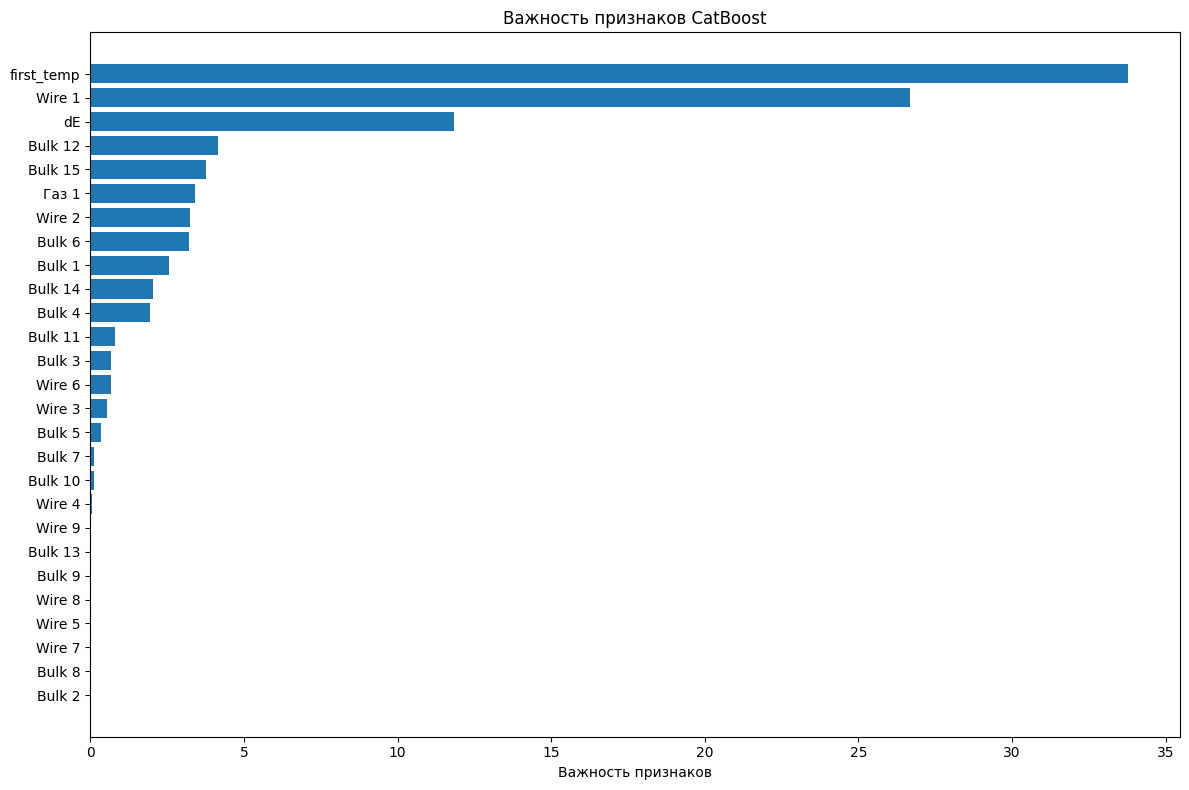

In [94]:
feature_importance = model_cat.get_feature_importance()
feature_names = model_cat.feature_names_

# Сортируем по важности
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])

# Создаем график
plt.figure(figsize=(12, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.xlabel('Важность признаков')
plt.title('Важность признаков CatBoost')
plt.tight_layout()
plt.show()

Это - прежде всего начальная температура стали и количество энергии, потраченной на нагрев сплава. Логично. А также количество поданного в расплав проволочного материала Wire 1.

График зависимости финальной температуры партии от количества энергии, поступающей в плавильный ковш:

In [95]:
data_graph = pd.DataFrame()
data_graph['dE'] = features_test['dE']
data_graph['final_temperature'] = target_test
data_graph['final_temperature_predicted'] = predictions
data_graph = data_graph.sort_values(by = ['dE'])
data_graph

,dE,final_temperature,final_temperature_predicted
192,0.000000,1583.0,1587.310333
931,26.187544,1589.0,1592.912369
1268,47.079648,1590.0,1593.591308
340,51.016560,1609.0,1607.844610
1922,51.796157,1594.0,1594.056463
...,...,...,...
177,1513.249742,1609.0,1600.249996
1865,1520.171775,1615.0,1610.705819
2091,1761.888070,1541.0,1599.667946
432,1774.993281,1618.0,1609.678268


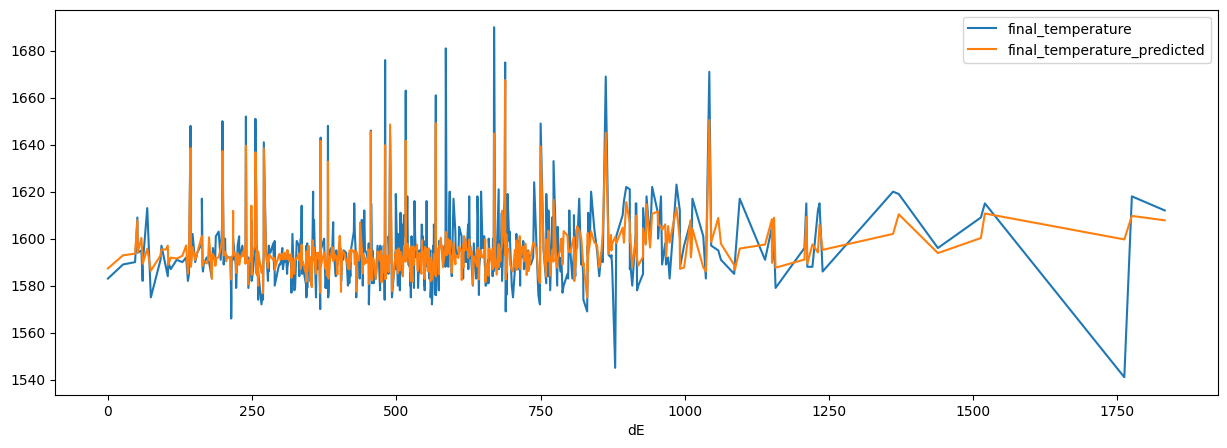

In [96]:
data_graph.plot(x = 'dE', y = ['final_temperature', 'final_temperature_predicted'], figsize = (15, 5));

График зависимости финальной температуры партии от начальной температуры ковша:

In [97]:
data_graph = pd.DataFrame()
data_graph['first_temperature'] = features_test['first_temp']
data_graph['final_temperature'] = target_test
data_graph['final_temperature_predicted'] = predictions
data_graph = data_graph.sort_values(by = ['first_temperature'])
data_graph

,first_temperature,final_temperature,final_temperature_predicted
1657,1526.0,1572.0,1582.446010
1951,1527.0,1578.0,1591.371188
1386,1527.0,1574.0,1589.662458
1572,1531.0,1581.0,1584.225097
2120,1532.0,1585.0,1588.748952
...,...,...,...
700,1650.0,1675.0,1667.546747
605,1651.0,1595.0,1600.298530
1789,1658.0,1633.0,1616.592380
1991,1660.0,1593.0,1596.605618


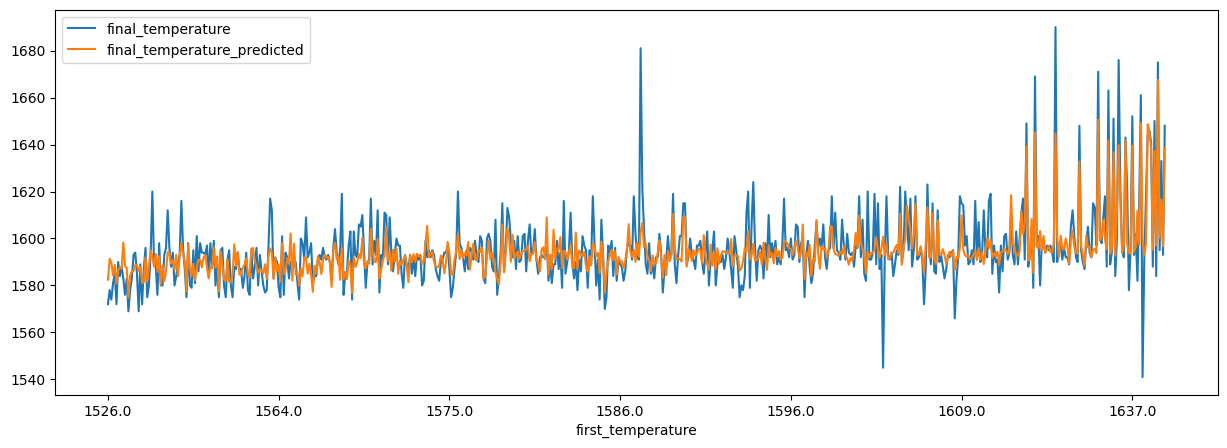

In [98]:
data_graph.plot(x = 'first_temperature', y = ['final_temperature', 'final_temperature_predicted'], figsize = (15, 5));

<a href="#toc">**к оглавлению**</a>

<a id="conclusion"></a>
**5. Общий вывод по работе:**

По результатам проделанной работы построена модель прогноза финальной температуры партии стали в зависимости от количества поданной в ковш энергии, легирующих добавок, объемов продувки газом. \
Модель наилучшего качества получилась с использованием библиотеки catboost, на тестовой выборке MAE = 6.74, что укладывается в предел качества, обозначенный в ТЗ. Соответствие ТЗ позволяет рекомендовать данную модель для дальнейшего использования в производственной деятельности. \
При этом факторами, в наибольшей степени влияющими на модель, оказались начальная температура партии стали, общее количество энергии, поступившей в плавильный ковш и количество подаваемого в расплав проволочного материала, обозначенного в базе данных как Wire 1.

<a href="#toc">**к оглавлению**</a>